In [47]:

import pandas as pd
file_path = "C:/Users/amita/github/team_lambda/Data/stock_cleaned.xlsx"
df= pd.read_excel(file_path)

In [31]:
df.head(5)

,Market Value (%),P/E,P/CF,P/B,Debt/Equity,ROE,ROA,Profit Margin,Op Margin,FCF Gr,...,Sector_Other,Sector_Pharmaceuticals,Sector_Professional & Commercial Services,Sector_Residential & Commercial REIT,Sector_Semiconductors & Semiconductor Equipment,Sector_Software & IT Services,PE_Category_Num,Quarter_Num,Quarter_sin,Quarter_cos
0,0.261441,2.678617,2.280683,1.380605,4.158586,24.099443,8.782066,2.157723,2.254373,3.663266,...,0,0,0,0,0,1,1,1,1.000000e+00,6.123032e-17
1,0.278499,2.745783,2.547655,1.431455,4.355491,20.890310,6.649256,2.171699,2.261916,3.578457,...,0,0,0,0,0,1,1,2,1.224606e-16,-1.000000e+00
2,0.287220,2.807734,2.668912,1.445721,4.313348,22.286109,8.316169,2.160965,2.250015,3.663266,...,0,0,0,0,0,1,1,3,-1.000000e+00,-1.836910e-16
3,0.276589,2.751567,2.601224,1.381344,4.195087,20.885223,6.710190,2.157310,2.280397,2.792343,...,0,0,0,0,0,1,1,4,-2.449213e-16,1.000000e+00
4,0.254987,2.556533,2.406652,1.178347,4.205696,21.427033,8.000966,2.152164,2.308252,2.394388,...,0,0,0,0,0,1,1,1,1.000000e+00,6.123032e-17


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
#  Split Buffett Buys and Controls
buffettBuys = df[df['Label'] == 1].reset_index(drop=True)
control = df[df['Label'] == 0].reset_index(drop=True)

In [ ]:
# Match Controls to Buffett Buys (1:1)
matchFeatures = ['Year', 'Quarter_Num', 'Market Value (%)', 'PE_Category_Num']

In [51]:
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[matchFeatures])


NearestNeighbors(metric='euclidean', n_neighbors=1)

In [52]:
distances, indices = nn.kneighbors(buffettBuys[matchFeatures])
matchedControls = control.iloc[indices.flatten()].reset_index(drop=True)

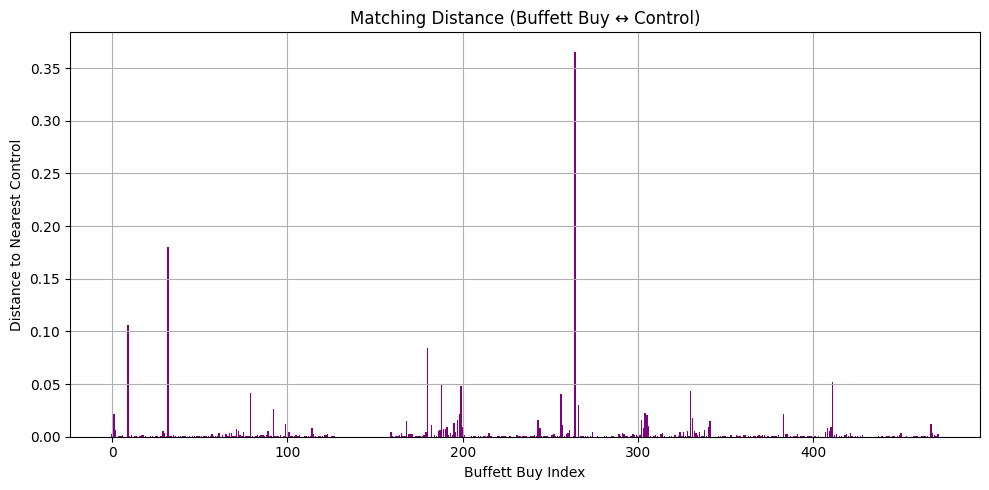

In [ ]:
#  Visualize Match Distances
plt.figure(figsize=(10, 5))
plt.bar(range(len(distances)), distances.flatten(), color='purple')
plt.xlabel('Buffett Buy Index')
plt.ylabel('Distance to Nearest Control')
plt.title('Matching Distance (Buffett Buy ↔ Control)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
print("Distance Summary:\n", pd.Series(distances.flatten()).describe())

Distance Summary:
 count    472.000000
mean       0.003847
std        0.020519
min        0.000000
25%        0.000149
50%        0.000467
75%        0.001345
max        0.365736
dtype: float64


In [ ]:
# Combine Matched Pairs
matchedPairs = pd.concat([buffettBuys, matchedControls], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
#  Feature and Target Split
X = matchedPairs.drop(columns=['Label'])  # Drop label column
y = matchedPairs['Label']

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
# Apply SMOTE + Undersampling on Training Set
apply_smote = False  # 🔁 Set True if you want to apply SMOTE after matching

In [60]:
if apply_smote:
    over = SMOTE(sampling_strategy=0.5, random_state=42)
    under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    resample_pipeline = Pipeline(steps=[('o', over), ('u', under)])
    X_train, y_train = resample_pipeline.fit_resample(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

c:\Users\amita\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [20:30:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#  Predict & Evaluate
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

In [62]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76        95
           1       0.77      0.68      0.72        94

    accuracy                           0.74       189
   macro avg       0.74      0.74      0.74       189
weighted avg       0.74      0.74      0.74       189

ROC AUC Score: 0.7942889137737962


In [ ]:

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

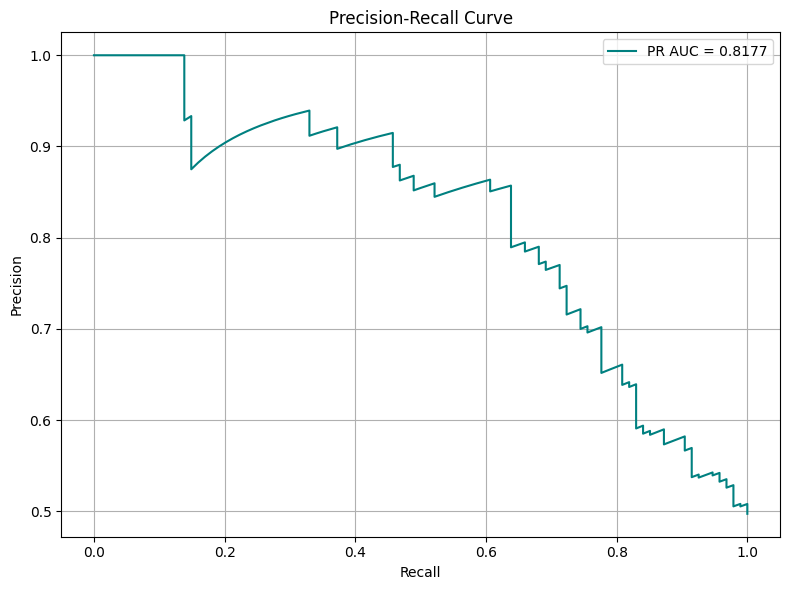

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

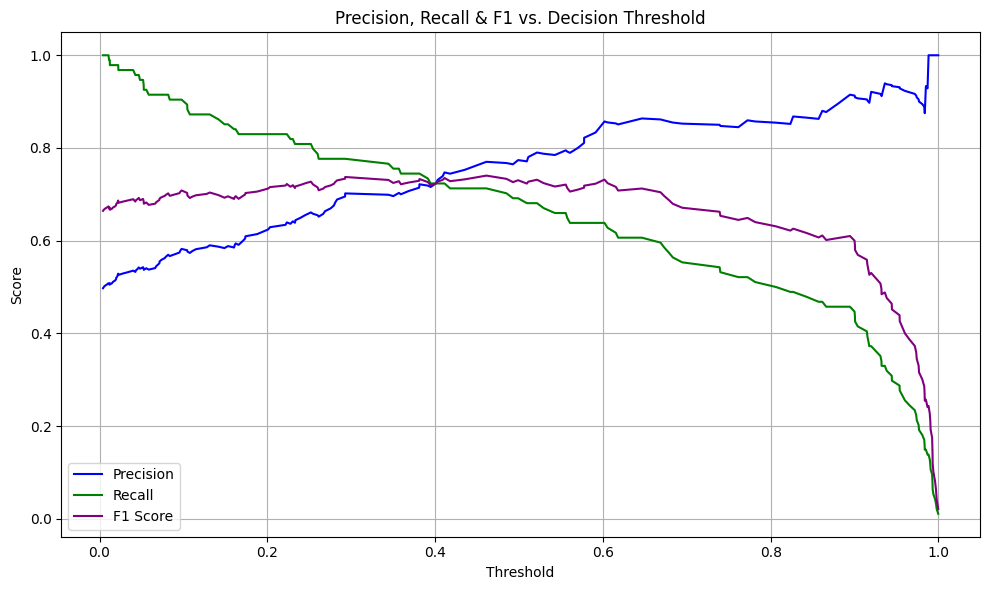

Best Threshold (Max F1): 0.46
Classification Report at Optimized Threshold:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        95
           1       0.77      0.71      0.74        94

    accuracy                           0.75       189
   macro avg       0.75      0.75      0.75       189
weighted avg       0.75      0.75      0.75       189



In [66]:
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]

# Precision-recall-threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='purple')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold (Max F1): {best_threshold:.2f}")

# Apply new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# New classification report
from sklearn.metrics import classification_report
print("Classification Report at Optimized Threshold:")
print(classification_report(y_test, y_pred_adjusted))
